# Introduction to SynthesisFilters.jl

This notebook demonstrates how [SyntheisFilters.jl](https://github.com/r9y9/SynthesisFilters.jl) works. Below we provide synthesized audio examples (Japanese) so that you are able to compare synthesis filters on your browser. Please read on.

In this notebook, the following synthesis fileters are demonstrated.

- **LMADF**: Log magnitude approximation digital filter for synthesis from cepstrum
- **MLSADF**: Mel-log spectrum approximation digital filter for synthesis from mel-cepstrum
- **MGLSADF**: Mel generalized-log spectrum approximation digital filter for synthesis from mel-generalized cepstrum
- **AllPoleDF**: All-pole digital filter for synthesis from LPC
- **AllPoleLatticeDF**: All-pole lattice digital filter for synthesis from PARCOR
- **LSPDF**: LSP digital filter for synthesis from LSP

### Related pacakges

- [MelGeneralizedCepstrums.jl](https://github.com/r9y9/MelGeneralizedCepstrums.jl): provides spectral parameter estimation based on mel-generalized cepstrum analysis.
- [SPTK.jl](https://github.com/r9y9/SPTK.jl): a thin wrapepr for SPTK
- [WORLD.jl](https://github.com/r9y9/WORLD.jl): a high-quality speech analysis, modification and synthesis system

In [1]:
using PyCall
matplotlib = pyimport("matplotlib")
PyDict(matplotlib["rcParams"])["figure.figsize"] = (12, 5)
using PyPlot

In [2]:
# https://gist.github.com/jfsantos/a39ed69a7894876f1e04#file-audiodisplay-jl
# Thanks, @jfsantos
include("AudioDisplay.jl")

inline_audioplayer (generic function with 2 methods)

In [3]:
using WAV
using DSP
using MelGeneralizedCepstrums # to esimate spectral envelope parameters
using SynthesisFilters

In [4]:
# plotting utilities
function wavplot(x; label="a waveform", x_label="sample")
    plot(1:endof(x), x, "b", label=label)
    xlim(1, endof(x))
    xlabel(x_label)
    legend()
end

function wavcompare(x, y; label="synthesized waveform", x_label="sample")
    plot(1:endof(y), y, "r-+", label=label)
    plot(1:endof(x), x, label="original speech signal")
    xlim(1, endof(x))
    xlabel(x_label)
    legend()
end

wavcompare (generic function with 1 method)

## Data

In this notebook, we use the follwoing audio data to analyze and re-synthesize. Let's see and listen the example.

<source src="data:audio/wav;base64,UklGRlzaAQBXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACABAAZGF0YTjaAQAmAD8AOQA/ADgAOwA4ADsAOQA6ADkAOAA3ADkANgA2ADYANgA2ADUAMgAxADIAMgAyADEAMQAwADEAMwAyADQAMgAwADAALwAuAC8ALQAqACkAKwAqACsALAArACoAKgAqACcAJwAnACYAJQAkACMAJQAkACUAIgAiACIAIAAkACEAIQAgACAAHwAeABoAGgAYABcAGAAUABIAEQAPAA0ADAAJAAgABQAIAAcABgAIAAUABAAEAAIAAAAAAAAAAAD///3/+//6//z//P/7//r/+//3//b/9//2//X/8f/z//L/8P/v/+//8P/v/+3/6//q/+n/6P/n/+f/5v/n/+P/5P/k/+L/4f/h/97/3f/e/93/3v/d/9z/2//Z/9j/2f/X/9b/1f/U/9P/0v/S/9P/0//R/8//zv/M/87/zf/N/83/zP/M/8z/y//L/83/zf/N/83/zP/O/8//zv/O/83/zv/P/8//zv/O/83/zv/L/8v/zP/N/8z/y//L/8n/yf/L/8j/x//I/8f/yP/H/8b/xv/H/8b/xv/F/8f/xf/G/8T/wv/B/8D/wv/C/8D/wP/A/7//v//A/7//wP+9/77/vv/A/7//wP/A/7//wf/B/8D/w//C/8H/wf/A/8D/wP/A/8D/wf/B/8H/w//C/8D/v/+//8H/v/+8/77/vP+7/7v/u/+7/7v/u/+5/7n/uP+5/7n/uf+7/7v/uv+6/7r/uv+3/7f/tv+3/7X/tv+5/7n/uP+4/7f/uP+5/7r/uP+4/7f/t/+1/7T/tf+0/7X/tP+z/7T/sv+z/7P/tP+x/7L/sf+w/7D/rv+v/67/rf+u/7D/sP+x/7H/sv+x/7H/s/+y/7T/tP+1/7f/t/+6/7v/uP+6/7j/uf+7/7r/vP+8/7z/vf+8/7z/v/+//8D/wf/B/8H/xP/E/8T/x//I/8r/yP/I/8n/zP/M/8v/zv/L/8z/z//R/9H/0//V/9b/1v/Y/9v/2v/b/97/3//e/9//4P/j/+P/4//k/+X/5f/k/+L/4//l/+X/5P/m/+b/5//o/+n/6P/q/+z/7f/u/+//7v/w//D/8f/y//L/8v/y//L/8f/1//f/+P/3//f/+v/5//r/+//7//3//f/9////AAAAAAAAAAABAAEAAQACAAUABgAFAAgABwAJAAkACgALAAkADQANAA4ADwAQABEAEAAPABEAEgASABAAEgASABEAEQATABYAFgAXABcAFwAZABgAGAAbABoAGQAbABwAHAAdAB8AIAAhACMAJAAlACQAJgAmACcAKQAqACkALAArACwAKwArACsALgAvAC8AMAAvADEAMgA0ADMANgA1ADYANwA3ADgAOQA5ADsAOwA9ADwAOwA7ADwAOgA7ADsAOgA6ADwAOwA8AD0APQA8AD8APQA+AD4AQABCAEEAQQBDAEMAQgBCAEQARQBEAEQARQBGAEUARgBGAEUARgBFAEUARQBHAEUARgBEAEQAQwBFAEUARgBFAEQARABHAEUAQgBDAEMARABBAEEAQgBDAEIARABCAEMAQgBGAEQAQgBCAEIAQQA/AD8APQA/AD4APAA5ADgANwA3ADYANQA0ADMAMwAwAC8ALgAtACsAKgAqACgAKQApACgAKAAoACYAJwAlACYAJgAlACIAIQAgACIAIQAfACEAIAAhAB4AGwAaABoAFwAYABcAGAAZABgAFQATABAAEAAPABAAEAAOAA4ADAALAA0ADgANAAwACwALAAwACwALAAwACgAKAAkACAAHAAUABQAFAAIAAwADAAQAAQD//wAA/////wEAAAAAAAAA//8AAAQAAwAEAAQAAgADAAMABAADAAAAAAAAAAAAAQD//wAAAAAAAP////////7//P/6//v/+f/7//z//v8AAAEAAgAEAAUACAAGAAcABAACAAAA/v8AAP//AAAAAAEAAQACAAIAAAD+//7/+v/8//v//P/8//v/+f/4//j/+f/4//n/+v/6//z//f8AAAAAAAAAAAAAAAD+//3//P/7//z//f/9////AAAAAAMAAAAAAAAAAAAAAAEAAAD///z///8BAAAA/v/+//3//P/4//T/9P/z//T/8v/0//P/9f/0//P/9f/0//X/8v/x/+7/7f/s/+v/6f/r/+r/6P/q/+j/6P/p/+X/5P/j/+P/4//h/+L/4P/e/97/3f/b/9j/1v/S/9D/0P/M/83/zP/P/8//z//P/9H/0P/L/8n/xv/F/8P/w/+8/7n/uf+7/7z/vv+6/7f/uP+4/7j/uf+5/7v/vv+8/7j/tP+x/67/rv+v/6z/rf+v/7L/tf+2/7X/s/+y/7L/sP+t/67/rf+v/7T/t/+8/73/vP+7/7j/sf+u/6n/ov+i/6L/pP+q/67/t/+8/8T/yv/K/8r/yf/H/8n/yP/D/8H/vf+8/7j/uf+5/7z/vv+8/77/wv/G/8j/yf/K/8r/zv/O/9H/0P/W/9b/1f/R/9L/zv/M/8b/xP/B/7//wf/B/8P/yv/P/9b/2f/Z/9b/1v/T/9X/0P/L/8b/wv/D/8D/v/+4/7//w//U/9r/3f/Z/9j/2v/Y/9j/z//H/77/vf+5/7z/vv/C/8b/yf/L/87/0f/V/9T/1f/N/8X/xf/H/9L/2P/c/+H/4v/o/+L/4//R/9f/y//K/8H/v//A/8r/1P/h/+n/9P/5//v/+P/y//b/+P8AAAEAAwACAA0ADgASAAQA/v/u/+v/5v/o/+v/7//z/wAACQAXACYALwAxACYAHQASAA4AEAAJAAYA8v/u/+b/6v/w////AgAFAAEAAwACAAkACwAFAP7/+f8AAP3/BAD//wAA8v/2//D//v///xUAFQAfABUAFAANAAEA8//W/7//sP+//83/8//6/xkAFwAtAC8ANwAlAAYA1P+r/4v/fP94/2//cv9v/4P/j/+q/67/u/+v/7H/qP+p/63/vP/Y//f/GwA8AGEAfgCcALIAyQDkAP0AGQEwAUkBXAFfAWUBTwE+ARoBBwEGATABegH7AZACOQPYA3EE6wRaBYgFHAXpAx8CTwDQ/uv9iv2W/cr9PP73/hAASwFkAgkDJwPWAlcC1QFoARcB8QDoAOsA8ADzAOoAsAAsAFz/aP6N/f78zfz//IX9Sf4x/y4AIwHzAXMChgIyAosBuwD0/1L/3f6R/mr+Zv6C/rD+4f7//vb+0P6d/nr+ef6i/vr+cv/7/4IA+wBSAXwBZwESAX4AxP8K/2f+9P24/bD92P0k/of+9v5c/6r/1//k/9b/uv+g/5P/kf+j/7j/zv/X/9D/qP9m/wX/nv4k/sD9Zf1N/YP8T/qi9yT1E/QA9Bf1Zfb69/z55vxMAKYDDgYFB0AGWQQfAjsAvv5v/Vb8l/up+2b87/2s/0gBDQJ3AocCswL2AmwDEASRBDMF3QW1BlYHAAguCAMIQQeqBhgGtQVRBRIF4wRmBKoDtgKKATQA4f7s/VX9Tf3q/Tf/9wDsAs4EYgZcB6MHNgcyBsUEKAN+AfD/sv4D/uP9I/6N/vj+Rf9k/23/eP+D/4D/i/+9/zUA5wC5AYgCKwN3A1YDywLuAdcAmf9r/nX90/yR/LX8Ov0I/vP+1P+QABEBVQFiAUwBIQHnAK8AgABiAGAAYwBXACsA3P9t/+r+YP7u/Zf9Zv1r/a79LP7V/o3/QwDVADQBXAFLAQkBngAbAJf/FP+x/mv+UP5N/mX+gf6l/rz+1/7o/gP/Ev8x/1f/kP/K/xMAUACLAKAAoAB0ADEAx/9f/+b+gv4o/gL+6f0P/jf+kv7X/kX/ff/O/8v/6/+t/9X/Sf6r+xj56PfM+Mb5PPul+0P8tfx2/hgAagEzAVcAmP48/WP8V/w1/AP8zvuk+2f7SPsr+7P6o/lp+H/3GPdh9

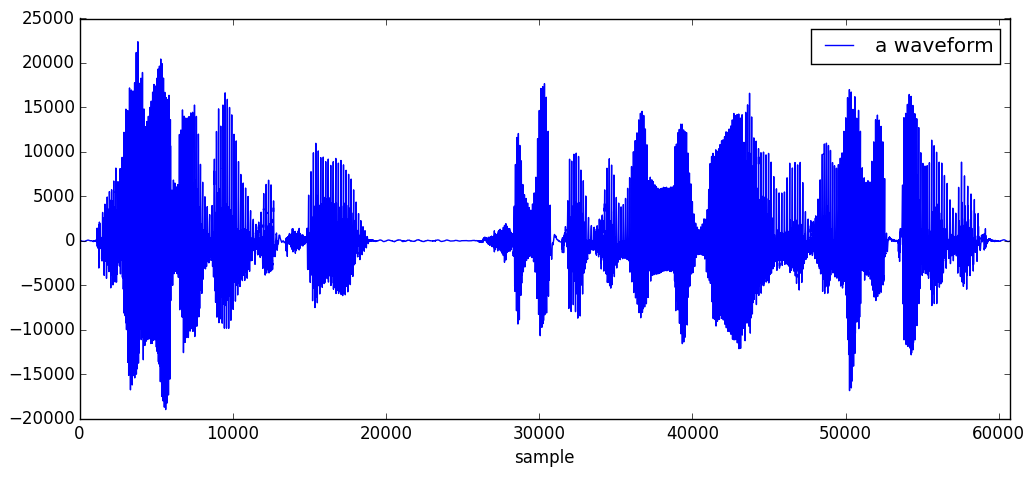

In [5]:
x, fs = wavread(joinpath(dirname(@__FILE__), "data", "test16k.wav"), format="native")
x = convert(Vector{Float64}, vec(x))
fs = convert(Int, fs)
wavplot(x)
inline_audioplayer(map(Int16, x), fs)

## Speech parameter extraction

To syntheisze a wavefrom, basically you need two speech parameters:

- excitation signal
- spectral parameters (e.g. Mel-cepstrum)

MelGenralizedCepstrums.jl supports extracting lots of spectral parameters.

### Excitation signal

In this notebook, we use a pre-extracted excitation signal, for test16k.wav in the example directory.

<source src="data:audio/wav;base64,UklGRvy0AwBXQVZFZm10ICgAAAD+/wEAgD4AAAD6AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YcC0AwBUbUk9ezATvS8q2z2AUm09fTDEvMxaFL1zcoS87SHWvQwGDL3gXuy9qhOVvLkgDT3R//e8BXyRvfVhcT089VI8V1MzveTcOT0/nty82h6+O8gPurvJfks9eHHrPfzopz1Ze5s9U3T9PeY9fD3xff68u8aAvW6SarsG3xq+6y5EPs/Hkr0imRu9N6udPWdjB76v6py8snZGvNk0Vb2Hq6M9otc4PYSIO72/N449OJ+UPBqiYb3tfWy9prBQPXqzLrzrZLg96ZMWPu8EOr2iP0s+t08svV+Sbb3eR8i9iOOXvTB+h7170DQ8sMqcPIMGQ72BJeK7gBK+vKrilju+OFm9ct8JvUix1Tx4w8G9ySGWvFhzDT76wzM9WYPhPCCdjj0rWoc8A+ILPTBoX72/CAI9SnDtPaFGwzy1nuS8/8t9PGwPDj4LJoi9KbUIvRZe7r2c5OM8iNGvPQzQpD36w449sQcNPoGjUD3SvhU99MAUvRHS0L3KPvq99s+ZPP1Pl7351pe6FVevvcnL4Txx/je9nAv7vFAoGz3YYrM9CIlIvUCtwzwr5as9i97YO1ErsLxcIv29OCYUPQbfPz08kUO9GtweuoHnH77dI1i93hr4O7BJDj58Osi89el6vTniDz0R5J08hbfvvMjbw70F5NG8kYtKPceSdL1cZOq8OCNzvb2lgz0eeeu70bwTPT0c2bwNl6w9taY3vd+K2bu8nCM9JhzAvDA0Gj2Q1EU9baWmPWHqOb7f3288h408PS9zOT4ljL29KJqavElufj3Gj0E9kA13PayYPL1SBxs+ZQQFvYeNR7ykHkq9VJP3PEnppz2Sz8g92FjSPW6HLz1z3xA8oCUpPYBFPD2QOCI+qnWlvGHQLjzn/CM9BLFUPRDN77zIAm69xLisPbJdqT27ZhS9Tuw1viG2qz1NSxq9/0qGPY4Bzb3VVK48zIf9PArhhD3tJgu+DLEgPSmM47ztKX69pQiMPdViq70wHAM9jo/bOCBjiL0IJkS70f4iPm/zsb2fyUO85T/GPVpKwLxCWtE9QDSfPdECrbw8ca48rcTnPA7rMj3gloM8+gMmvJjAO7z8wda8NpJyvQGCnL0ilNW7VEHVvIWwuT21pqK9wAMQPkPFl7yFy4o9Xt/MPOkFJ73Y8zW+OShavbs8nz001IU8/slDvefiWrxzeI+9qWu9PORfEL3MA2298mUXujTZbr2kZ6O9MjCHPeD+4L1UIvy6Z/2uvWRcw7wj6CU8KmfjvWKP1zwgT9m9QXXbPZsBvbwL6iu+q+6svdYIBL3trX+9Mu9xPMoPSj36fp29B8Kzu1eK07s2p189mTpgvZio0D0Zx369gwIAPHKYZr5baZi9HgdHvQI1972rY7I9kTK0vJ4i0L1EPdM9GSOkvaLiCL5NoGi8BLGRvIShSj27CpW9KVXNvWSgmL2Espu9EwCwPSB9Gj19pqW8e5PBPSyeUz0BPCa9wWPzPWjaAb5kcIq93WFOvW75fj17a0A+/dp6O6ywpD09lGw9UFHpO4yi2rzBPsO9jUrUvR8libwBGW69mTiFPdjcSr1p/MW9fiKAvS6W5DszIR29IPnmPF83373yp7c9NHRNPiJ3WD2/t1e9eHMGvW9bvD3zZqU9e0KWvZABSDxKor89a9cqPjUpFr2Sit05NyGvPY4dl73JsUY8h7EivVkQKb3ng+g9U9WFPQu3G71a0Qw+KK8wPoyAYb1SCHO9XJUkvfs6Ljyu07O7zRWpvcvU273Icj69ruPdPalwXL2tlZc8PbQ2PW+vZL3YNlC943TcvDm2uL2w9og9qeMRPd9IlT2WKJC96H74PM/1xb26Ruc74rN/O8o+lbqX6eC6VhQ/PJh2S71VDYm9NeBOPFbxSryG1G69SD+PPIX70DwMdxS832ScvD8ezD1oTG09tIkKvlSSkL2FdQi+NnIBvdKSmj12p3K9yORnPX1D8b3TV7m95bxRvTXlAT1gYnQ9Q6QRPohN271chKa86vv7vKz6srwLVw2+TcG5PJ03Ar6/WEc9hepkvVgBMzwRl5Y9hY2yu003jD0u5gU9TzYgvHoGETwpenq9ZZ8KPqZ5sLtO/iE9OiNxvZW31bw69fK91OhvORXsAj2Aeaq9UFWevbpxHD5BTlq90SMxPM7p9b3Gd6M82ZBYPWoWdj26Tp+95XwVPbICvTzc6U49S6eVvfnHDr7u5kM8HVR8vcCYm73/OZA9I6/VvQDFGDsvu1C93YyNPa/NX700US0+Bn2evISBFb6UMCU+AnjNPNfElL0ylyw7zz4evsvzAD6qava8Fruvvf7It7wW6ba94ayNvAv0PrxWy/u9FApGvO6RbbzvEBe+KohLPtkseT28VFA97wFjPAGmLz2VaLm9Kw6cPFd3yDy4XBw+juylPDVBuz1yuUU8AaAvvCzPfLwAP3i9/fzXvKSKpb0xAxK8q/wrPZha0D3BMlA81F2nvQu6O70obp09ND1DvWL0ZT2T5lM9rEN6PfX8oT3wk5G9GAebvbX7y7zkJsO7mprAvep7Uz1F6SG9M18nPky1R728C3U9YhgGvZAqSj3Q/iC9btFAPbPZAD0zG0U9dFNKPWTivj3MsV69RD67vYBvsj2NvIs82wytvE36CT5zZLS9Tbxhvf3ItzzOHz68tHMmPclxgLzLe+c9rr+BvRctvD1jVb89Wl4BPho2Nz2sBHQ9vIWoPbg8zz2GnqQ8jmp5vVa0jj1maWA7l9oNvoubtb0T+VO9D5APPQ/z2z1K35Q9CEOwvZF8HrwUmcC9u1Tou70ICr531cI8x1GgPb5WoTz5l9k90DGRvbibmr0mO+y7Jv9YPeTeWj1G9hO7ii1APaV+zr2+SMs8hfT2PHB5Krw+saw9pT2fusTd4LtaKDg9oKPLvKJ/Fz6dkDa9PQquvV8JqzwjIcY8SYgJPl/BXj1VvQy8tiBCvCVM/D3/3Nu9QAtjPRmkXz3PdNg9CA8zvHSWgTsrFhA8D7+EPS1AvzyD37y82FGJvOBDY7ztzVA9XR4XvdFA2T2cT408ewECPj2Xzr3PXBK9fgDLPUZ9PT3HK+68dufBvOsPj72+Izi9u1yQPf7uDz11N5y8qQlZOxy9ED1gzbm9IJm3PadZCLz8ua69vrCjPLMzfz2wrWS8vfpNPQydL735n6C85J9bvPyngb2JrdU7wYijPaV4hrz+Pba9F4DKvBPkFT0YH1a7ahudvLwY7b0usbQ9RO1bPFFyJL3R2LO9ySqKvRKAvz1JE6K92/QCPWmmmr1uydM8MIm6vWucTj3MvKm9JlMwvrOsKz5a9Ik9Ttl9vKh7ub0wVU49v1kFvkbmsDx3DJg9PSecufnwgT2HSIA7IX2hvN2u0D2YB6O7L+R8Pswwnb0Bxmu7wFqEPYDhBz4eSPE9l6rIPXzNXLvbHx69k9fIu65Iir3k44Q8lsvoPCkGO76zzZo9rQSUvJx2pbyIQzO9Ly6Muhbqxzzq+jS8bLRePJ03s7wgx2q835qJPJgghjzZ8429FQQXPWxU7Lz8t4M840advfeADb0BVPy9+t7CvJBhCb07ocK9X6YgvW7iQz6wqtg8jNY7vMZx0L0KiOa9f7X1PJrd2byy/ZM99lruvZ6cyz3RpjO9Ti8aO6BeDj5nlU09d8cmvUYXib1iVja6OUXKPYSNuz1OHde8daNevDeZCj026c09haI3uukRDr1h1V89fhM7PZ4TJD2qrjG9vP3OvGdECLy4aAs9uQwlPcz8er36IKg9HzYPPoHKXL38L708Q+7qOy9MzjzEWJY9b3MIvqTyy715i6K9M2MlPVjSjTpzgjm9U18ZvKjDtr2DeYU8PqjpPVoW7jwXeJ89gWqovaab0L0pK

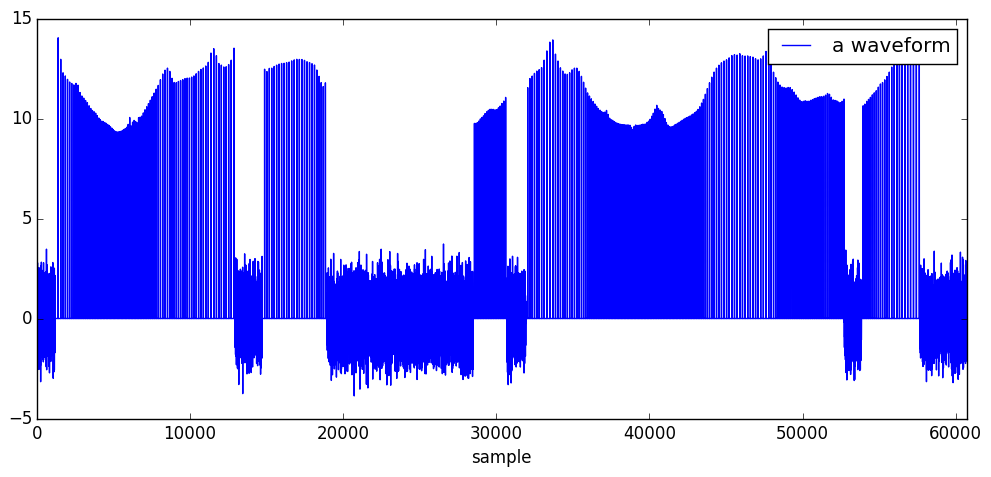

In [6]:
# Note about excitation
# fs: 16000
# frame period: 5.0 ms
# F0 analysis: esimated by WORLD.dio and WORLD.stonemask
# Excitation genereration: perioic pulse for voiced segments and gaussian random
# values for un-voiced segments
base_excitation = vec(readdlm(joinpath(dirname(@__FILE__), "data", "test16k_excitation.txt")))
wavplot(base_excitation)
inline_audioplayer(base_excitation ./ maximum(base_excitation), fs)

## Split audio signal into overlapping time frames and apply windowing

This ia a basic step before mel-genrealized cesptrum analysiis. Note that windowing is essential for mel-generalized cepstrum analysis.

In [7]:
framelen = 512
hopsize = 80 # 5.0 ms for fs 16000
noverlap = framelen - hopsize

# Note that mgcep analysis basically assumes power-normalized window so that Σₙ w(n)² = 1
win = DSP.blackman(framelen) ./ sqrt(sumabs2(DSP.blackman(framelen)))
@assert isapprox(sumabs2(win), 1.0)

# create windowed signal matrix that each column represents a windowed time slice
as = arraysplit(x, framelen, noverlap)
xw = Array(Float64, framelen, length(as))
for t=1:length(as)
    xw[:,t] = as[t]
end

# col-wise windowing
xw .*= win;
@show size(xw)

size(xw) = (512,753)

(512,753)

## Spectral parameter estimation

You can extact lots of spectral parameters using MelGenrealizedCepstrums.jl. In the follwoing example, we extract mel-cepstrum from the windowed signal and then show the spectral envelope estimte.

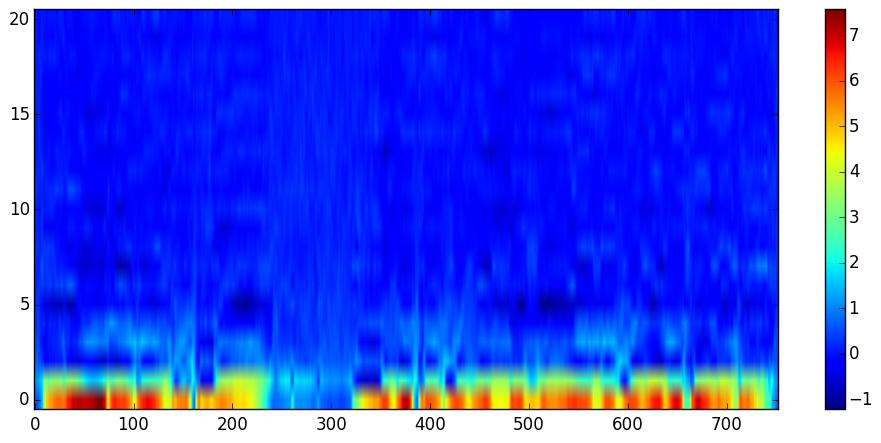

PyObject <matplotlib.colorbar.Colorbar instance at 0x7fcc0f712998>

In [8]:
c = estimate(MelCepstrum(20, mcepalpha(fs)), xw)
imshow(c, origin="lower", aspect="auto")
colorbar()

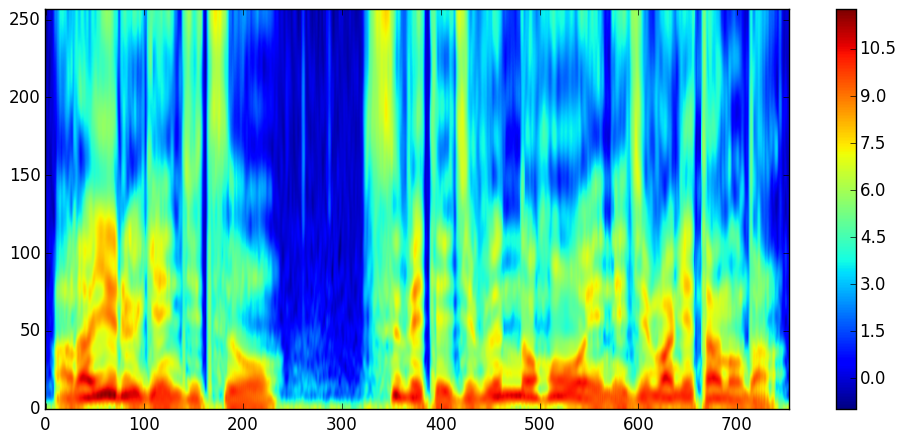

PyObject <matplotlib.colorbar.Colorbar instance at 0x7fcc0e247368>

In [9]:
# Let's see spectral envelope estimate
imshow(real(mgc2sp(c, framelen)), origin="lower", aspect="auto")
colorbar()

## Compare synthesis filters

Let's compare syntheiszed waveform with various synthesis filters.

### Synthesis from Cepstrum

<source src="data:audio/wav;base64,UklGRoTaAQBXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACABAAZGF0YWDaAQABAAAAAgADAAMAAwADAAEAAQD/////AAD+//3//v/+//z//f/8//z/+//7//3//f/+/wAAAQAAAP//AAD+/wIAAAAAAAMAAAABAAIAAQAEAAUABAAHAAcABwAHAAkACQALAA0ADAARABAAEAAQAA8ADwARABEAEQARABEAEgARABEAEQAQAA8AEQARABEAEwASABMAEQARABMAEwASABMAFQATABMAEgATABUAFgAXABoAGwAdAB0AHAAcAB4AHQAeABwAHgAdAB0AHgAgAB8AIAAiACIAIQAfACEAIgAgACAAHQAcABsAHQAbABkAGQAZABcAFAATABQAEQAPAA0ADQALAAoACAAIAAYABAAEAAEAAQABAAEA/f/8//z//v/8//r//P/7//z/+v/+//3//f/9//3///8BAAQABQAGAAgACwAPAA8AEgAVABcAGQAaAB4AIgAjACIAJgAnACoAKgAtADAAMgAxADQANQA1ADgANwA5ADkAOAA5ADwAOgA6ADwAOwA9AD0APAA9AD0APgA+AD0APQA8ADoAOQA4ADcAOAA1ADcANQA1ADUANAAwAC8AMAAuACwAKwApACkAJgAkACMAIQAeAB0AGQAYABUAEwASAA4ADQAJAAkABgABAP7//P/5//f/9f/y/+//7f/s/+j/6P/l/+P/3f/b/9n/1P/U/9H/zf/O/8r/xf/E/8L/wf++/7r/uP+1/7X/tP+y/7L/sv+v/7D/rf+r/6r/q/+t/6z/rf+u/6//r/+u/67/r/+v/7D/sP+v/6//sf+x/7P/sv+1/7n/uv+5/7v/vv/B/8H/w//H/8v/y//N/9H/0v/U/9b/2P/c/97/4P/l/+r/6//s//D/8//1//b/9//6//3//v8AAAIABAAEAAUABQAHAAgACwAKAAwACgALAAwADAAMAAwACwAKAAoACQAIAAgACAAHAAYABgAHAAMAAgD///7//v/7//v/+P/1//P/8v/x//L/7v/t/+v/6f/l/+X/4f/h/97/3f/c/9v/2v/a/9j/1//V/9b/1//W/9X/1P/T/9P/0//R/9D/1P/S/9P/0f/S/9P/1f/T/9X/1f/X/9f/1f/W/9X/1P/W/9X/1P/U/9X/1f/Y/9f/1f/Z/9r/2f/Z/9f/2v/a/9j/2f/X/9j/2P/V/9X/1f/R/9b/1//X/9f/2f/X/9n/2P/c/93/4P/h/+L/4//j/+T/5P/l/+b/6v/r/+z/7P/v/+//8v/z//f/+f/6//n/+v/6//r/+//7/////v8BAAEAAwACAAUABQAIAAkACwALAAoADAAMAA0AEAAQAA4AEAAPABEAEAAUABIAFQAXABoAHAAfACEAJAAlACUAJgAnACUAIwAhACEAJAAlACUAJAAjACMAIAAgACEAIAAiAB8AHQAcABwAHQAcABwAGQAYABgAFgAXABYAFgAWABQAFwAWABQAFAATABUAFgAWABUAFwAVABcAFwAaABoAGQAZABoAGwAbABsAGgAbABoAHQAdACAAHgAeACAAIgAiACEAHwAdAB4AHgAeAB4AHgAcAB8AHgAdAB0AHgAdAB4AHQAcABsAGQAYABkAGAAWABQAEwATABIADwAQABAADwANAAkACgAIAAgABQAEAAEAAgD+//n//P/8//z/+v/6//X/9f/2//b/9v/1//T/9v/2//z/+v/7//z///8DAAYABgAEAAQAAQACAAIA/P/8//v//P/+/wAAAwAGAAoADQAOABAAEgAPABAADgANAAoABwABAP7/+//4//b/+//+/wIAAgAAAAEAAQAFAP//AAD6//j/+v/8//r/+P/2//f/+//7//r/+P/6//z//f//////AQABAAAA/v/+/////v8BAAYABwAMAA0ADwATABEADgAGAAMAAQAAAP//+//8/wMACgAUABcAFgAYABkAGAARAAsAAAD///7/BAAEAAgABwAFAAUABAADAP///f/4//f/9P/x//D/9f/2//f/9//4//r//P/5//H/6v/o/+r/7P/z//b/AQAIABAAFAATABAACwAFAAEA9f/o/93/2//c/93/4P/f/+L/5//3/wQAFwAhACwALwAtACgAHAAFAOr/0P+//7L/sv+0/8L/0v/v/wEAGQArAEMAVABfAGEAYwBuAHgAhQCNAJMAlQCbAJUAlACMAIIAbABUADUAKQAmADwAWACEAJ8AugCzAKMAiQBnAEcAIgARAAsAKABFAHQAgQCJAGkATwAmAP7/vv98/zb/Bf/3/gX/NP9h/53/xP/0/wwALQA6ADUAGQDx/9b/x//c//P/HwA2AFIATwBNACwAFwD2/9v/vf+u/7j/5/8/AKkAHwF2Aa4BrgGSAUEB9wCpAH0AVwBFADoASQBpAJQAvQC8AKsAcQBGAC4APABcAIAAmQC2ANAA7gDsANUAtACaAHYAOwDm/4b/J/8E/yD/ff/s/0YAdgBqAEMAKwAqAB0A1f9W/7/+SP5E/qH+Ov+q//n/JwBRAIMAugDUAK0AYgAOANr/vP+y/77/5v8zAJ0AEgGEAbwBvAGgAYYBdQExAdIAQwCy/0L/Ff8i/07/ff+1//n/ZwABAcoBeALkAg4D6AKTAiQCygFpAQABhgAiAOT/4v8iAIUAxgC7AFUAv/8a/43+Hv72/Rf+hv4z//n/+AD/AegCYwNrAwADVAKhAUABMgF+AfYBmwJbAyEE/gTkBXcGZQbABa4ErgO3AiICngEDAScAOP9R/uf9Lf4u/5cAOwLyA54FRwcPCX4KUQtiC9YK3QmOCJ4HtwYCBgEFLQQeAzACbwH7AHYAoP+//jj+Mv60/p7/fgDvACUBnAFNAk8DAwR4BDwE3wMRAzoCrgCs/nz8gfoW+Uf4J/in+K75TPtw/aj/hAGZAswCCQLgAIv/Of7h/LL7ufpN+mv6VPt3/OL9+P68/8b/eP/o/mH+2v04/X787/vl+4T8uP0V/zcAzwDeALcAhQB2AFQACwCB/xr/CP+B/zwAIgHEAR4C9gFnAZYA3f+c/1j/Rv/q/qH+PP4g/vH9y/3x/Lf7+fn2+D/4q/hT+XD6ePvJ/EX+zP/VADkBwQB6//v9l/y0+xb7uPpF+hr6RPpB+6H8DP7K/in/G/9C/0P/oP8RALgAQQHgAXIC7QLdAqsCaAKQAogCWAK9AUwBigFjAmQD7QMXBPAD7wP5AzEEEASzAwwDkAI9Ai0CKgIdAuoBtQGZAZgBpAGsAasBlgGGAXsBfAFxAWEBRQEoAQYB6wDSAL0ApwCXAIsAgQB5AHQAbgBnAGEAWwBVAE4ASABCAD0AOAA0ADAAKwAnACMAHwAcABkAFgAUABIAEAAPAA4ADQAMAAsACgAJAAgABwAGAAYABQAFAAQABAADAAMAAwACAAIAAgACAAEAAQABAAEAAQABAAEAAQABAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD+AswH9Q6YFD0ZbhsEHZ0d8B3lG5YXChFsCu8EnQFnABgAHwAxAGQBWAMiBskIBAvsCwAMbAvpCiwKXQkpCJoGyQQwAxECaAEWAfcA8ADpAAoBWAHKASgCaQJ2Al0CKAL3AcYBkgFSARABywCQAGcAUgBIAEEAPgA8AD0AQQBJAFAAUwBQA

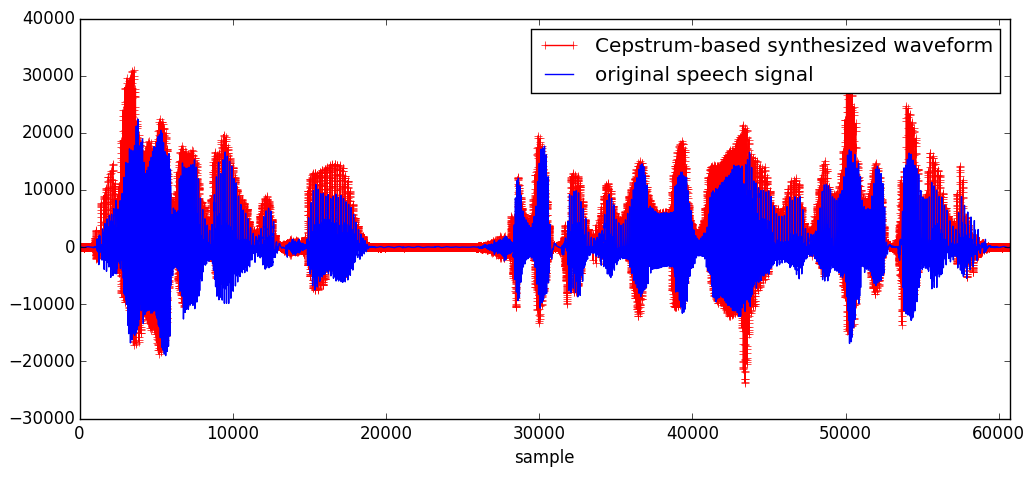

In [10]:
c = estimate(LinearCepstrum(25), xw)
y = synthesis(base_excitation, c, hopsize)
wavcompare(x, y, label="Cepstrum-based synthesized waveform")
inline_audioplayer(round(Int16, clamp(y, typemin(Int16), typemax(Int16))), fs)

### Synthesis from Mel-Cepstrum

<source src="data:audio/wav;base64,UklGRoTaAQBXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACABAAZGF0YWDaAQABAAAAAgADAAIAAgACAAAAAAD+//7////+//3//v/+//3//v/9//3//f/9//////8AAAIAAwACAAEAAgAAAAQAAgABAAMAAAABAAIAAQAEAAQAAwAFAAQAAwADAAQAAwAFAAcABgAKAAkACAAIAAYABgAGAAcABgAHAAYABwAGAAYABwAFAAUABwAHAAcACQAJAAoACQAKAA0ADQANAA0AEAAOAA4ADQAOABEAEgATABYAFwAYABgAFgAVABcAFgAXABYAFwAXABYAGAAZABgAGQAbABsAGgAYABoAGwAaABoAGAAYABkAGwAaABkAGgAaABoAGAAYABoAGQAZABgAGQAZABkAGQAaABkAGQAaABkAGQAaABwAGAAYABkAHAAZABgAGgAaABoAGQAcABsAGwAaABsAHAAdAB8AHwAfACAAIQAkACMAIwAlACYAJgAlACcAKQApACYAKQApACoAKQAqACwALQArACwALAAsAC4ALQAuAC8ALgAvADIAMAAxADQAMwA1ADYANgA4ADgAOgA7ADsAOwA8ADwAOwA8ADwAPgA9AEAAQABBAEIAQQA/AD8AQQBAAD8APwA/AD8APgA9AD4APQA7ADwAOQA5ADgANwA3ADUANQAzADUAMwAvAC4ALgAsACwALAAqACkAKAAoACUAJgAkACMAHgAcABsAGAAZABcAEwAUABAADQALAAoACQAFAAIAAAD9//3/+//5//n/9//0//T/8P/u/+z/6//s/+n/6f/o/+f/5f/i/9//3v/b/9v/2P/V/9P/0v/P/87/y//L/83/y//H/8b/x//G/8P/w//E/8b/w//C/8P/wf/A/7//vv/A/8D/vv/B/8P/wP+//7//wP+//77/vP+8/77/vP+9/77/vf+9/73/u/+9/73/vv+9/77/vP++/77/v/+//8D/v/+//8D/wP/A/8H/wv/D/8P/xf/G/8T/xP/C/8P/xf/E/8X/xP/D/8P/xP/E/8f/xf/G/8X/xf/C/8T/wv/E/8L/w//E/8T/xf/G/8X/xf/E/8f/x//I/8f/x//F/8b/xv/F/8P/x//F/8b/w//E/8X/xv/E/8X/xf/H/8X/w//C/8L/wP/C/8D/wf/A/8L/wf/E/8L/wf/E/8X/w//D/8D/w//C/8D/wP+//7//wP+9/73/vP+6/7//v/+//7//wP+//7//vv/C/8L/xP/E/8T/xP/E/8T/xP/E/8X/x//I/8f/xv/I/8f/yP/J/8r/zP/L/8n/yf/J/8j/yv/J/87/zf/Q/9D/0v/S/9T/1f/Y/9n/2//a/9r/2//c/93/4P/f/+D/4f/h/+P/4//m/+X/6P/r/+7/8P/y//T/9//4//j/+v/7//n/+P/3//j//P//////AAAAAAEA//8AAAIAAgAFAAQAAwAEAAUACAAJAAoACQAKAAwADAAOAA4ADwARABEAFgAVABQAFQAVABcAGQAZABkAHAAZABsAGwAeAB4AHgAfACAAIQAhACAAIAAhACAAIwAjACcAJQAlACcAKQApACkAJwAmACcAKAAnACgAKQAoACsALAAqACsALAAsAC4ALAAsACwAKwArAC0ALAArACoAKwArACsAKAApACkAKQAoACUAJwAlACYAJAAkACIAIwAhABwAIAAgACAAHgAfABsAGwAcABwAHQAcABsAHQAcACMAIQAgACEAIwAmACkAJwAkACIAHwAeAB0AFgAWABUAFQAVABUAFwAZABwAHQAeAB4AHwAcAB0AGwAaABcAFQAQAA4ACwAIAAUACgALAA4ADAAJAAkACQANAAkACgAGAAcACwAOAA4ADAAKAAwADgANAAoABgAGAAYABQAFAAUABwAIAAgABwAIAAkACAALABAAEAATABMAFAAXABQADwAHAAQAAQABAP///P/9/wMACwAUABUAEwAUABQAEwAMAAYA/f///wAABwAIAA0ADAALAAkABwADAP3/+v/1//P/8f/w//H/+f/+/wAAAgADAAUABgABAPf/7//s/+//8f/5//3/BwANABQAFgAUABEACwAFAAEA9f/q/+H/4f/j/+f/6v/o/+v/7//9/wcAFgAeACYAKQAoACQAGwAGAO7/1f/F/7n/uP+4/8X/0P/s//j/DwAfADgARwBTAFUAWgBnAHYAhQCSAJgAnACeAJcAkACDAHEAWAA7AB4AFAAYADYAWQCKAKkAyADBALYAmwB8AFoANwAkAB4ANwBRAHgAfgB6AFQAMQAGANj/l/9T/xH/5v7j/gD/O/94/7n/5f8LABoAJQAhAAYA5P+0/6X/of/L/+z/IQA1AEoAOAAlAPb/1f+t/5H/eP94/5b/5/9WANwAWAG4AeIB4QGwAVsBAAGxAH0AWwBKAEwAYwCMALYA1gDFAKMAWwAnAA4AHABDAHEAnwDVAA4BRAFUAT4BDAHWAIMAIQCk/zH/xv6s/tD+Pv+x/xYAQgA1AAQA6P/f/9X/k/8q/67+X/53/uf+eP/X/wYAFwAiADgATQBIAAMArv9g/0v/XP+J/8f/EABtANIAOwGaAb4BogFqATkBHQHgAJwAOgDe/5v/kv+0/+j/EQA5AGYAuwA0AdwBZAK3AsoCoAJQAvgBswFnAQcBlQAxAPP/6f8dAGYAiABeAOL/Rv+q/jP+2/3P/Qr+l/5a/zgAQgFGAhUDZQM7A54CxQHwAHIASgB5ANgAbgEmAusCwgOeBB0F+QRLBEsDdwLMAZYBfgFVAewAbQDp/8v/OAAuAVsCogPkBBkGRgegCJsJBwq0CeUItwdQBk4FYQSnA7ICBQI4AaYASwAvAOX/KP9M/sT9vv1V/lb/YQD+AHwBKwITAx4EuQTcBDAESwPvAYwAhP4i/Kf5ePfp9Qj11/RQ9Un26PcN+nD8jP4cANkAyABPALL/Bv9J/pj9A/3S/Aj91/2n/on/4//X/wv/C/7y/CT8jfsn++X6F/vx+439mv+yAUwDPgR2BHQEOwQWBLUDIAMtAlsB0ADOAP4AWAFoAUcBxAAWAFb/5v4F/zf/m/++/+7/+f8sACgA+P/2/ob9n/uA+q75//lr+kz7+Pv6/BP+S//q//b/Fv+V/ef7oPrj+bH5rPmz+d35ZfqH+/f8NP6w/qn+SP4z/ir+rP5z/5MAmQG2ArADfASMBFgE2gOuAywDngK0ATYBcQFnAnwDNQSTBMUEGwV6Bc0FtgVBBZgEGAThA/ADDQQCBLgDSAPUAmoCCgKtAVAB/AC7AJoAmgCzANIA5wDlAMkAnQBqADcAAwDM/5H/Vf8f//T+1v6//qj+kP54/mf+Y/5s/oD+mv60/s3+4f7x/v3+A/8C//3+9f7s/uf+5v7p/vD++f4E/xH/IP8y/0X/W/9w/4f/nf+y/8f/2v/p//X//v8DAAYACAAJAAoADAAPABMAGAAeACUALAA0ADsAQgBIAE0AUgBVAFYAVwBVAFMATwBLAEYAQQA8ADcAMwAwAC4ALAAqACkAKAAnACYAJQAjACEAHwAdABoAFwAUABAADQAJAAYAAwAAAP7//P/7//r/+f/5//j/+P/4//j/+P/4//f/9//3//b/9v/1//T/9P/0//T/9P/0//T/9P/1//b/9v/3//j/+P/5//r/+v/7//v/+//8//z//P/8//3//f/9//7//v/+/////////wAAAAAAAAEAAQABAAEAAQACAAIAAgACAAIAAgACAAIAAgACAAIAAgADA6wHew6AE4YXKBlWGpgatRqKGEoUAQ7WB9ECAwDp/rX+cv5h/vz+nADaAgwFdwbdBoYGDAbNBccFpwUCBZQDagHa/kf88Pnk9x/2n/SF8wTzRvND9Lv1WPfO+Pb50/p0+9v79fur+/X65fmm+Gb3R/Za9aP0KPT38yT0vPS99RP3nvg6+

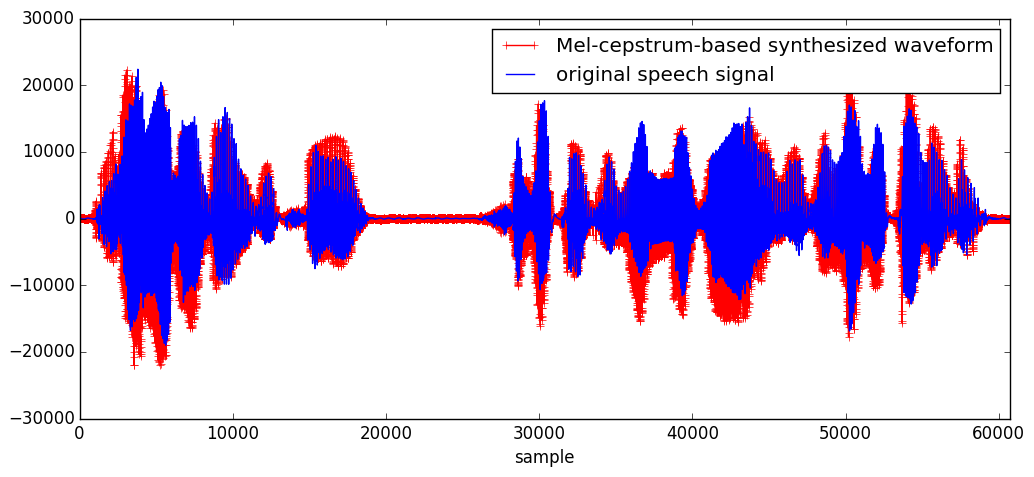

In [11]:
c = estimate(MelCepstrum(25, mcepalpha(fs)), xw)
y = synthesis(base_excitation, c, hopsize)
wavcompare(x, y, label="Mel-cepstrum-based synthesized waveform")
inline_audioplayer(round(Int16, clamp(y, typemin(Int16), typemax(Int16))), fs)

### Synthesis from Mel-generalized cepstrum

<source src="data:audio/wav;base64,UklGRoTaAQBXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACABAAZGF0YWDaAQABAAAAAgADAAIAAgACAAAAAAD+//7////+//3//v/+//3//v/9//3//f/9//////8AAAIAAwACAAEAAgAAAAQAAgACAAQAAQACAAIAAQAEAAQAAwAFAAQAAwADAAQAAwAFAAcABgAKAAkACAAHAAYABgAGAAYABgAGAAYABwAGAAUABgAFAAUABwAHAAcACAAIAAkACAAJAAwADAAMAAwADwANAA0ADAAOABAAEQASABUAFgAXABcAFQAUABYAFQAWABUAFgAWABUAFgAYABcAGAAaABkAGQAXABkAGgAYABkAFwAXABgAGgAZABgAGQAaABkAFwAYABoAGQAYABcAGAAYABgAGAAZABgAGAAZABgAGQAaABsAFwAYABgAGwAYABgAGgAaABoAGQAcABsAGwAbABsAHQAeACAAIAAgACEAIgAlACQAJQAnACgAKAAnACoALAArACkALAArAC0AKwAtAC4ALwAuAC8AMAAvADIAMAAyADIAMQAyADUAMwA0ADcANgA5ADoAOgA7ADwAPQA+AD4APwBAAD8APwBAAEAAQgBBAEQAQwBFAEUARQBCAEMARQBFAEMARABDAEQAQwBCAEMAQgBAAEIAPwA/AD0APQA+ADsAPAA6ADsAOgA2ADYANQA0ADMAMwAxADEAMAAwAC0ALgAsACwAJwAlACQAIQAiACAAHQAeABoAFgAVABQAEwAQAA0ACgAIAAgABgAEAAUAAwAAAAEA/P/6//j/+P/5//b/9v/1//T/8v/v/+z/6//p/+j/5f/i/+D/3//d/9z/2P/Z/9r/2P/V/9P/1P/U/9H/0f/S/9P/0P/Q/9D/zv/N/8z/y//M/8z/yv/N/87/zP/K/8r/yv/J/8j/xv/G/8f/xf/F/8b/xf/E/8T/wv/D/8P/xP/C/8P/wf/C/8P/w//D/8T/wv/C/8L/wv/B/8L/w//D/8P/xf/F/8P/wv/A/8D/wf/A/8H/v/++/77/vv++/8H/vv+//77/vf+6/7z/uf+7/7n/uv+6/7r/u/+8/7r/uv+5/7z/u/+8/7v/u/+4/7n/uP+3/7b/uf+3/7j/tP+1/7b/t/+0/7b/tf+2/7T/sv+y/7H/r/+x/6//sP+v/7H/r/+y/7D/r/+y/7L/sP+x/63/sf+v/67/rf+s/6z/rf+p/6n/qf+m/6r/q/+r/6v/rP+q/6r/qf+t/63/r/+v/6//r/+v/6//rv+u/7D/sv+y/7H/sf+y/7H/sv+z/7X/t/+1/7T/s/+z/7L/tP+z/7j/t/+6/7r/vP+8/77/v//C/8P/xv/F/8T/xv/H/8j/zP/K/8v/zP/M/87/zv/R/9H/1P/W/9r/3P/e/+D/4//k/+T/5//o/+b/5f/k/+b/6v/t/+3/7//u//D/7v/v//H/8v/1//T/8//0//b/+f/6//v/+v/7//3//v8AAAAAAQADAAMACAAIAAgACAAIAAsADQANAA4AEQAPABAAEQATABQAFQAVABYAFwAXABcAFwAZABgAGwAcACAAHgAeACEAIgAjACMAIQAgACIAIgAiACMAJAAjACcAJwAmACcAKAAoACkAKAAoACgAJwAnACkAKQAnACYAJwAnACcAJAAmACYAJgAkACIAIwAiACMAIAAhAB4AIAAdABkAHAAdAB0AGwAbABcAGAAZABgAGAAYABcAGQAYAB8AHQAdAB0AHwAiACUAIwAgAB8AGwAbABkAEwATABEAEgASABIAFAAWABkAGgAbABwAHAAaABoAGAAYABUAEwAOAAwACgAGAAQACAAKAA0ACwAIAAgACAAMAAcACQAFAAYACQAMAAwACgAJAAoADQALAAgABAAFAAUABAAEAAQABwAIAAgABwAIAAkACQAMABAAEAATABMAFAAXABQADwAHAAQAAgACAAEA/f/+/wUADAAWABcAFQAXABcAFQAOAAkA//8BAAIACQAKAA8ADgAMAAsACQAGAP///P/3//X/8//y//P/+/8AAAMABAAFAAgACAADAPn/8P/t//D/8f/5//3/BwANABQAFgATABAACgAEAAAA9f/p/+D/4f/j/+f/6//q/+z/8f/+/wkAFwAfACcAKQAoACUAGwAGAO7/1v/G/7n/uP+3/8P/zv/p//b/DQAdADcARwBUAFYAWwBmAHQAgwCPAJQAmACaAJQAjQCCAHEAWQA8ACAAFwAcADsAXgCQAK8AzwDJAL8ApwCKAGoARgA0AC0ARQBeAIMAiACDAF0AOwASAOP/of9b/xf/6f7k/v7+Of92/7j/5f8MAB0AKQAnAAsA6P+2/6T/nf/F/+b/HAAyAEcANgAkAPX/0/+q/4r/bv9t/43/4f9XAOUAaQHQAf8BAALRAXwBHgHLAJEAagBWAFcAcACbAMcA6QDYALYAbQA3ABkAIwBFAHAAngDWABUBUgFnAVUBJAHsAJQAKwCn/y7/vf6f/sD+Lv+j/wwAPgA1AAYA6f/c/83/if8f/6X+WP50/uj+fv/h/xQAJQAuAD8ATgBCAPr/ov9T/0D/Vf+G/8n/FQBzANgAQAGfAcYBrAF1AUABIQHkAKMARgDv/6z/nv+5/+f/DQA0AGAAswArAdIBXQK1AtACrAJgAggCwgF0AREBnAA3APj/7/8kAHAAlABrAPD/VP+4/j/+5P3T/Qf+j/5R/y8APgFHAhoDbQNGA6sC1QEAAYAAUwB6ANEAYQEXAtwCtQOSBBEF7gRBBEMDcgLJAZUBewFOAeEAXgDV/7L/FgD/AB0CVwORBMQF9wZbCGQJ3QmUCc4IqAdEBkMFVASXA6AC+AE4AboAdQBtAC0AbP+B/t/9uf0s/gv/+P9+APIApQGdAr4DcgSpBAoEKgPNAWgAX/7++4j5XffS9fT0x/RC9Tz22ff6+Vn8dv4NANcA0wBgAMH/Bv8u/ln9mvw8/Eb88vyq/YL+4P7l/jb+WP1h/LD7LvvX+qH63Pq++2X9f/+lAU8DUwSgBLIEkgSABCgEjQOIApgB5gC4ALwA7QDeAK0AMQCl/yH/AP93//7/qQD9AEgBVgF1AUYB2wCW/+n90/ud+sf5Ifqb+oX7Nfw2/Un+c//+//H//P5v/cb7mfoJ+gr6OPpo+qr6N/tN/KH9tf7+/sH+LP7r/cb9Pf4H/y8APgFgAloDJwQ7BA4EmANzA/wCgAKyAVYBsQG7As8DcgSwBMME+wQ7BXEFQwXGBCcExwO+A/sDOwRCBPwDhgMJA5UCJwK9AVkBAwHGAK4AuwDkABIBLwEoAfwAugB2ADwADADe/63/ev9P/zH/IP8O//D+w/6O/mL+S/5M/mH+f/6g/sD+3v75/g7/Gv8Y/wz/+f7m/tr+2P7d/uf+8f76/gT/Dv8b/yr/Ov9L/13/c/+N/6v/yP/h//X/AQAHAAkACQAIAAcABgAGAAkADQAUAB0AJQAtADQAOwBCAEoAUgBaAGEAZgBpAGoAaABkAF4AVwBOAEYAPgA4ADQAMQAwAC8ALgAtAC0ALQAsACsAKgAoACYAIwAgAB0AGAATAA4ACAADAP7/+v/3//T/8//y//L/8v/z//T/9P/1//X/9f/1//T/8//z//L/8P/v/+7/7f/s/+z/7P/s/+3/7v/w//H/8//1//b/+P/5//r/+v/7//v//P/8//z//P/8//z//P/9//3//v/+////AAABAAIAAgADAAQABAAEAAQABAAEAAQABAAEAAMAAwADAAMAAwAAA6QHbw50E4IXMRlvGsQa8BrYGKkUdw5lCHsDwADD/6//kf+k/2cAHwJlBJkGEwiKCEYI2QeiB50HfwfeBmcFIgN6AOj9tPvk+Vb48PbK9TT1ePWX9kD4/Plp+2n8Gv2m/Q/+Lf7L/df8dPvq+X/4Wvd89tb1afVM9aH1ffbS93X5KfvA/

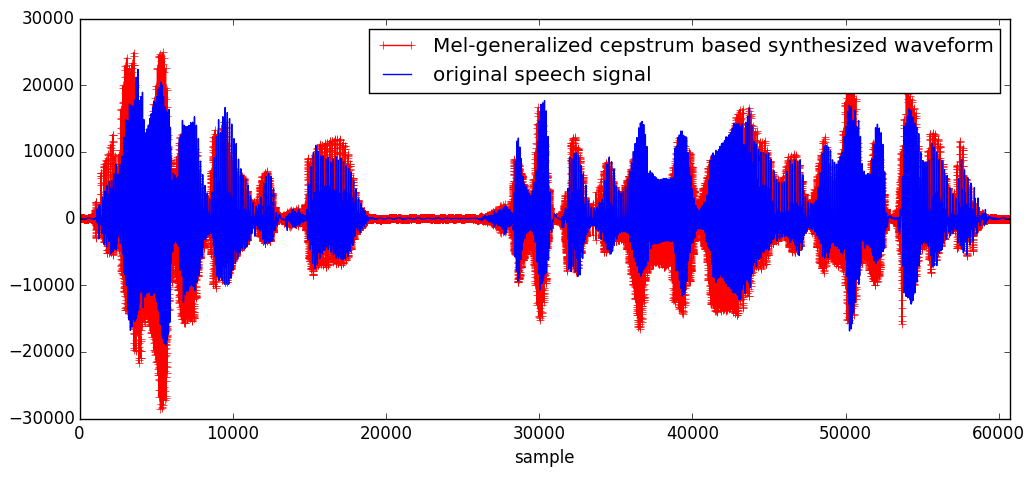

In [12]:
c = estimate(MelGeneralizedCepstrum(25, mcepalpha(fs), -1/4), xw)
y = synthesis(base_excitation, c, hopsize)
wavcompare(x, y, label="Mel-generalized cepstrum based synthesized waveform")
inline_audioplayer(round(Int16, clamp(y, typemin(Int16), typemax(Int16))), fs)

### Synthesis from LPC

<source src="data:audio/wav;base64,UklGRoTaAQBXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACABAAZGF0YWDaAQABAAAAAgADAAIAAgACAAAAAAD+//7////+//3//v/+//3//v/9//3//f/9//////8AAAIAAwACAAEAAgD//wQAAgABAAQAAQACAAIAAQADAAQAAgAEAAUAAwADAAUABAAGAAgABgALAAoACQAJAAcABwAIAAgACAAIAAgACAAIAAcACAAHAAYACQAJAAkACgALAAsACgAKAA0ADQANAA0AEAAOAA8ADgAPABEAEgATABYAFwAYABgAFwAWABgAFwAXABYAFwAXABcAGAAaABkAGgAcABwAGwAaABsAHQAbABwAGQAZABkAHAAbABoAGwAbABoAGAAZABoAGQAYABcAGAAXABgAFwAYABcAFwAXABYAFwAYABkAFQAWABcAGQAXABcAGQAZABkAGAAcABsAGgAaABsAHAAdACAAIAAhACIAIwAmACYAJwApACoAKgApACwALgAuACwALwAvADAALwAwADIAMwAxADMAMwAyADUAMwA0ADUANAA1ADgANgA2ADkAOAA6ADsAOwA8AD0APgA/AD4APwA/AD4APQA+AD4APwA+AEAAQABBAEIAQQA/AD8AQQBAAD8APwA+AD8APgA8AD0AOwA6ADsAOAA4ADYANgA2ADMAMwAwADIAMAAsACsAKgAoACcAJgAkACMAIgAhAB8AHwAdABwAFwAVABQAEAARAA4ACwALAAgABAADAAEAAAD9//r/9//0//T/8v/w//D/7//r/+v/6P/l/+P/4//k/+H/4f/g/9//3f/a/9f/1//U/9T/0f/P/8z/zP/K/8j/xf/G/8f/xv/D/8L/w//D/8D/v//A/8L/v/++/8D/vf+9/7z/u/+9/73/u/++/8D/vv+8/73/vf+9/7v/uv+6/7z/uv+6/7v/uv+5/7n/t/+5/7n/uv+5/7n/t/+4/7j/uP+4/7j/t/+3/7f/t/+2/7b/t/+2/7b/t/+5/7b/tf+z/7T/tf+z/7T/sv+x/7D/sf+x/7T/sf+x/7D/sP+t/67/rP+t/6v/q/+s/6z/rf+t/63/rP+r/63/rv+u/63/rf+s/6z/rP+r/6r/rf+s/6z/qv+r/6z/rf+r/6z/rP+u/63/qv+r/6r/qf+r/6n/qP+o/6n/qf+r/6r/qf+s/6z/q/+r/6n/rP+r/6n/qf+o/6n/qP+m/6b/pv+j/6f/qP+o/6n/qv+o/6r/qP+t/63/r/+w/7D/sP+x/7D/sP+w/7D/tP+0/7T/tP+2/7b/uP+4/7v/vf+9/7z/vP+9/7z/vv+9/8H/wP/E/8P/xv/F/8j/yP/L/8z/zv/P/87/0P/R/9L/1f/V/9T/1v/W/9n/2f/c/9z/3//h/+X/5//q/+3/8P/y//H/8//1//P/8f/x//H/9v/3//j/+f/4//n/9//4//r/+//9//3/+//8//7/AAABAAIAAAABAAEAAQAEAAQABQAGAAUACQAJAAgACQAIAAwADQANAA4AEQAPABEAEgAVABUAFQAVABcAGAAYABgAGAAZABgAGwAcAB8AHgAeACAAIgAiACEAHwAeAB8AIAAgACAAIQAfACMAIgAhACEAIwAiACQAIwAiACEAIAAgACEAIQAfAB4AHgAeAB4AGwAcABwAHAAaABcAGAAWABcAFQAVABIAEwAQAAsADgAPAA8ADQANAAkACgALAAoACwALAAoADAAMABIAEQASABMAFgAaAB0AHAAbABsAGAAYABcAEAAQAA8ADwAPAA8AEQASABUAFwAXABgAGAAWABcAFQAUABAADgAIAAYABAAAAP3/AQADAAYABgACAAMAAwAHAAEAAgD9//3/AAACAAIAAAAAAAEABgAGAAUAAwAGAAcACQAKAAoADAANAA0ACwALAAsACQAMABAAEAAUABQAFgAbABkAFgAOAAsACAAHAAQA///+/wQACgATABUAEwAVABYAFQAOAAkA/v//////BgAHAAwACwAKAAoACAAGAP///P/3//X/8//x//H/9//6//z//f/9////AAD8//P/6//p/+3/8P/5//7/CgARABkAHAAZABUADgAIAAMA+P/s/+P/4//l/+f/6f/l/+b/6P/1////DgAWACAAJAAkACQAHAAJAPL/2//L/7//vv++/8f/0v/q//b/CgAbADMARQBSAFgAXwBuAH4AjwCaAKAAoQCkAJwAlwCKAHoAXwBFACYAHAAdADkAWACFAKEAvAC1AKYAjgBvAFAALgAiACAAQABfAIkAkACNAGYASQAiAPz/wf+E/0j/If8e/zP/ZP+O/8L/3v8BAAwAHgAdAAwA6//G/7j/vP/n/xAARwBgAHYAZABQABwA9f/D/57/ff94/5P/3f9LAMkARQGdAcwBxAGbAUEB7ACYAGkASABEAEsAbgCZAMQA4ADLAKIAVAAaAPj/AwAkAFMAfwC6APUANQFKAT8BFgHoAKAAPwDF/0n/1/6u/s/+O//C/zkAhACIAGQAQAArAAkAtf83/7L+Vv5u/uH+gP/t/ysARABRAGQAdABsACgA1f+N/4L/oP/b/yUAdgDOACkBfgHIAdMBnQFKAf0A0gCTAF0AEQDM/5j/j/+m/8n/2v/l//L/KQCOADEB0AFJApYCpQKPAl0CNgL1AZQBDwGQAC0AAQASAEoAZQBAANL/SP++/lH+/v3r/Rv+lP5L/xsAJAEtAg4DdwNxAwADWQKxAV0BVgGgARMCuAKDA1cEOgUYBpgGZwahBXQEaANtAt4BZQHdABgARP91/hX+S/4d/0IAmQEQA5EEMgYMCKsJwgovCw4LjgqnCfUIEAggB7YFZQTrArIBxgA5AKj/wf7R/UL9S/3j/ef+2v9eAJ8AMwERAk4DMgTIBJUELARKA2gC5gDx/tf88fqh+er47PiB+YD65vu7/Zn/OgE8ApACBgIaAQAA7v7b/fL8M/zd++b7hvxL/Uf+9v5c/yz/uP4o/sP9jf1Z/SL9F/18/Vn+j/+xAF0BWAG/AAQAYf8a//v+8v7T/vT+cP9pAHwBhwIOAxcDewJ0ATgANP/F/nj+fv5e/m3+a/6h/pj+W/44/Z77h/lK+Hn34feV+Mr5+/qI/FH+IgBbAcABIQGW/9j9U/x3+wH72Pqb+p367foA/GT9rf4b//z+af4h/vj9c/5S/5AAyQETA0MEMQVaBQoFTASnA7ACqAF5AND/HAAxAYcCgQM0BKgELwWMBb8FUQV3BGADlgIwAjYCZQKQApICfAJgAjgC9gGKAQEBZADo/6z/y/8sALoARgG3AfMBBALnAaABLAGWAPL/XP/4/tb+9P41/4T/yv/9/xkAJAAaAPr/x/+S/2v/Yf96/6//7v8jAEMASgA5ABMA3v+f/17/KP8K/wz/MP9t/7b/+/8wAFIAXgBXAEAAHQD0/87/tf+u/7r/0//w/woAGgAfABoADQD6/+b/1f/L/83/3f/4/xgANwBOAFkAVwBKADUAGgD+/+b/1P/N/9L/4P/0/wkAGgAkACgAJQAeABMACAD+//j/+P/9/wYADwAXABoAGAARAAcA/P/x/+f/4v/h/+b/7//7/wgAEgAYABoAFwARAAkAAAD4//L/7//v//L/9//8/wAAAgACAAEA/v/7//n/+P/4//r//v8CAAcACgALAAsACAAEAP//+//3//T/9P/1//f/+////wMABQAHAAcABgAEAAMAAQAAAP////8AAAEAAQABAAEAAAD///7//f/8//z//f/2AqYHjw7SExgY/xleG8Ub+hv9GfkV+Q8dCmQFpwKhATsB+QC+AIABAgM3BTMHswgSCeQIhAiBCIcIcwjSB18GKQSnAVv/T/2F+9H5Pfjo9mv2E/fQ+AX7NP3u/icADwHgAXkCfgK9AVEAl/7+/OP7PfvL+lH65Pmx+e75sfrZ+xT9Jv4O/

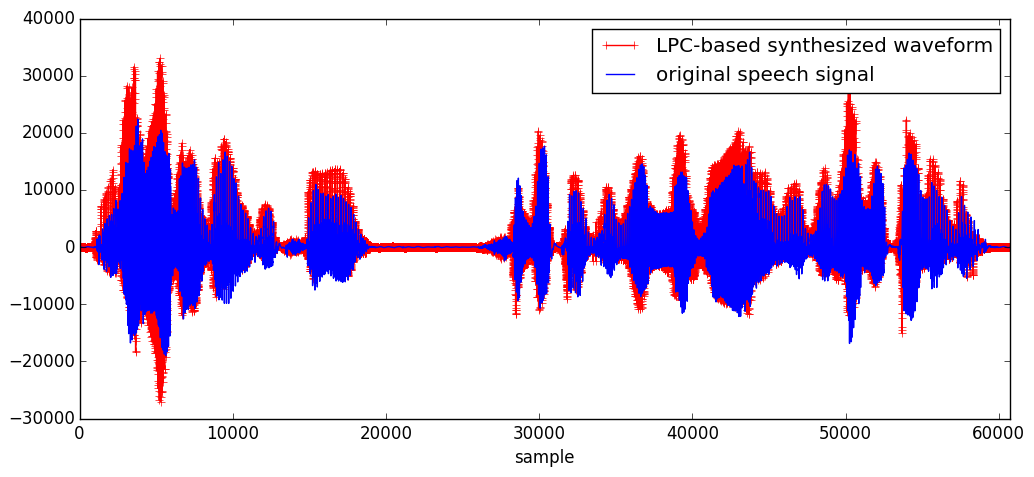

In [13]:
l = estimate(LinearPredictionCoef(25), xw, use_mgcep=true)
y = synthesis(base_excitation, l, hopsize)
wavcompare(x, y, label="LPC-based synthesized waveform")
inline_audioplayer(round(Int16, clamp(y, typemin(Int16), typemax(Int16))), fs)

### Synthesis from PARCOR

<source src="data:audio/wav;base64,UklGRoTaAQBXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACABAAZGF0YWDaAQABAAAAAgADAAIAAgACAAAAAAD+//7////+//3//v/+//3//v/9//3//f/9//////8AAAIAAwACAAEAAgD//wQAAgABAAQAAQACAAIAAQADAAQAAgAEAAUAAwADAAUABAAGAAgABgALAAoACQAJAAcABwAIAAgACAAIAAgACAAIAAcACAAHAAYACQAJAAkACgALAAsACgAKAA0ADQANAA0AEAAOAA8ADgAPABEAEgATABYAFwAYABgAFwAWABgAFwAXABYAFwAXABcAGAAaABkAGgAcABwAGwAaABwAHQAbABwAGQAZABkAHAAbABoAGwAbABsAGQAZABoAGQAYABcAGAAXABgAGAAZABcAFwAYABcAFwAYABkAFgAWABcAGgAYABcAGQAZABoAGQAcABsAGwAbABsAHQAeACAAIQAhACIAJAAnACYAJwAqACsAKgAqAC0ALwAvAC0AMAAvADEALwAxADMANAAyADMANAAzADUANAA1ADUANAA1ADgANgA3ADkAOAA7ADsAOwA8AD0APgA/AD8APwA/AD8APgA+AD4AQAA+AEEAQABBAEIAQQA/AD8AQQBAAD8APwA+AD8APgA8AD0APAA6ADsAOAA4ADYANgA2ADMAMwAwADIAMAAsACsAKgAoACcAJwAkACMAIgAhAB8AIAAdABwAFwAVABQAEAARAA4ACwAMAAgABAADAAEAAAD9//r/9//0//T/8v/w/+//7//r/+v/5//l/+P/4//j/+H/4P/g/97/3P/Z/9f/1v/T/9P/0P/O/8v/y//J/8f/xP/F/8b/xf/C/8H/wv/B/77/vv+//8D/vf+9/77/vP+8/7r/uv+7/7v/uf+8/77/vP+7/7v/u/+7/7n/uP+4/7r/uP+4/7n/uP+3/7f/tf+3/7f/uP+2/7f/tf+2/7b/tv+2/7b/tf+0/7X/tP+0/7T/tf+0/7T/tf+2/7T/s/+x/7H/s/+x/7L/sP+v/67/r/+v/7H/r/+v/67/rv+r/6z/qv+r/6n/qf+q/6r/q/+r/6v/qv+p/6z/rP+s/6v/q/+q/6r/q/+p/6j/rP+q/6v/qP+p/6r/rP+q/6v/q/+t/6v/qf+q/6n/qP+p/6f/p/+n/6j/qP+q/6n/qP+r/6v/qv+q/6j/q/+q/6n/qf+n/6j/qP+l/6X/pf+i/6f/p/+o/6n/qv+o/6r/qf+t/67/sP+x/7D/sf+x/7H/sP+x/7H/tf+1/7X/tf+3/7f/uf+5/73/v/++/77/vf++/73/v/++/8L/wv/F/8T/x//G/8n/yf/M/83/0P/Q/8//0f/S/9P/1v/W/9X/1//X/9n/2f/d/9z/3//i/+b/6P/r/+3/8P/y//L/9P/1//P/8v/x//L/9v/3//j/+f/4//n/9//4//r/+v/9//z/+//8//7/AAAAAAEA//8AAAEAAQADAAMABAAFAAUACAAIAAcACAAHAAsADAAMAA0AEAAOABAAEQAUABQAFAAUABYAFwAXABcAFgAYABcAGgAaAB4AHAAdAB8AIAAgACAAHgAdAB4AHwAfAB8AIAAeACIAIQAgACAAIgAhACMAIgAhACAAHwAfACEAIQAeAB0AHQAeAB0AGgAbABsAGwAZABYAGAAWABcAFAAUABEAEgAPAAoADQAOAA4ADAAMAAgACQAKAAkACgAKAAkACgALABEAEAAQABIAFAAYABsAGgAZABgAFgAWABQADQAOAAwADAAMAAwADgAPABMAFAAUABUAFgATABQAEgARAA4ACwAFAAMAAQD9//r//v8AAAMAAgD//wAAAAAEAP//AAD7//v//v8AAAAA/v/9////AwADAAIAAAADAAUABgAHAAcACgALAAsACQAJAAkABwAJAA0ADgARABIAFAAZABcAEwAMAAkABgAEAAIA/P/8/wEACAARABMAEQATABQAEwAMAAYA/P/9//3/BAAGAAoACgAIAAgABgADAPz/+f/0//P/8v/x//L/+P/7//3//f/9//7//v/5/+//6f/o/+7/8v/8/wEADQATABkAGgAVABAACAACAP7/9f/r/+X/5v/q/+z/7v/p/+j/6P/z//z/DAAVAB8AJAAmACcAHwALAPL/2f/H/7v/uv+6/8X/0f/r//r/EAAhADoASgBVAFkAXgBsAHsAiQCSAJYAlgCYAI4AhwB4AGYATAAzABoAFQAcADoAWwCHAKEAtgCrAJcAewBYADgAGAATABsAQwBlAIsAjACAAFMALgAEANn/of9u/0n/Pf9V/3n/rf/Q//T/AAANAAUAAADx/9f/v/+r/7n/1f8TAD8AbwB4AHoAVAAsAOj/tf+D/2j/X/94/7X/FgCSAA4BfgHCAdgBuAF6ARIBtgBmAEIANABCAFoAhACyANUA5AC+AIgAMQD1/9n/6/8XAFEAigDOABABSgFTATIB9wC5AGkABwCV/yj/zf69/vP+aP/r/1IAiQB/AFIAKwASAOr/lP8i/7T+e/6x/i//v/8QADEAOQA/AE0AVQA/APP/qf99/5T/z/8VAFgAlwDeACwBdgG0AbIBcAEZAdQAuwCTAHAALwDq/7D/nv+s/8f/0P/U/93/FAB/ACwB1wFaAqsCuAKbAl8CMALoAYIB+wB9AB0A9/8RAFIAdABTAOT/Vf/F/lD++P3i/RH+iv5D/xcAJAExAhQDgAN5AwYDWgKvAVgBUAGaAQ0CswKAA1UEOQUYBpkGZwagBXIEZANoAtgBXwHYABMAQP9y/hP+Sv4e/0UAnQEUA5UEMwYLCKgJvwotCw0LjwqnCfYIEAghB7gFaATwArcBygA9AK7/yf7c/VD9W/3y/fP+5f9nAKcAOgEVAk4DLQTBBI8EKgRLA2sC6AD0/tv8+fqt+fn4/fiQ+Y768/vI/aT/QwFAApACAQIUAfj/5/7W/e78Mfzd++j7i/xR/U3++/5h/zD/vP4s/sf9kP1b/ST9GP17/Vf+iv+qAFQBTwG3AP3/Xf8Y//z+9f7X/vj+b/9gAGkBbQLxAv4CagJuAT0AQP/Y/o7+lv50/nr+af6N/nP+L/4S/Y37mPl/+M73SvgI+Tr6YfvZ/IP+KQA5AYIB4QBu/9/9jPzZ+3/7Zvsu+y37bftf/Jf9s/4F/+j+bv5J/j7+yP6o/9sABAI1A0IEAQX8BI4EzgNGA4ECsQG0ACsAhQCYAdwCuANCBIcE5AQjBU4F7wQ0BEADlQJCAk8CegKaAosCYAIwAvoBtwFYAekAbQAPAOf/DQBmAOAAUQGkAcIBuQGNAUQB2wBdANb/Xf8O//f+Ff9P/5D/xP/m//T/+f/w/9r/tv+S/3j/df+N/7n/6v8PACEAHAAFAOH/t/+I/1v/N/8o/zL/Vv+M/8n/AAAnAD0AQwA7ACgADwDx/9b/xf/C/8z/4P/2/wgAEgATAA0ABAD4/+3/5P/i/+j/9/8OACcAPABKAE0ARgA4ACUADwD7/+r/3//c/+L/8P8AAA8AGwAhACEAHgAYABEACQADAAEAAQAFAAsAEAATABEADAAFAPz/8//s/+j/5//q//D/+f8DAAwAEwAVABQADwAJAAIA/P/2//L/8f/y//T/+P/7//3//v/+//z/+//6//r/+//9/wAAAwAGAAkACgAJAAYAAwD+//r/9//1//T/9f/3//r//v8CAAQABgAGAAYABQAEAAMAAgABAAAAAAAAAAAAAAAAAP///v/9//3//P/9//7////4AqgHjg7NEw0Y8hlRG74b9Rv5GfAV7g8PClkFmwKTASUB3ACeAGAB5gIgBSYHrggWCe0IkQiOCJYIgQjbB1oGEQR8ASL/Ef1G+5D5+feh9if22/aq+PH6Lf3u/ikAFQHtAYwCkgLLAVQAjv7s/Mz7Ivup+in6tvmC+cb5lPrL+xX9M/4l/

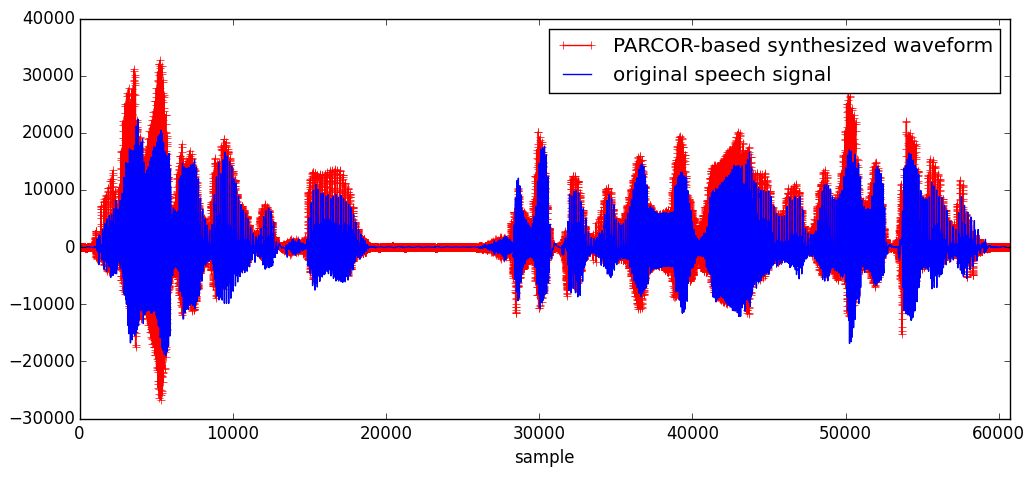

In [14]:
l = lpc2par(estimate(LinearPredictionCoef(25), xw))
y = synthesis(base_excitation, l, hopsize)
wavcompare(x, y, label="PARCOR-based synthesized waveform")
inline_audioplayer(round(Int16, clamp(y, typemin(Int16), typemax(Int16))), fs)

### Synthesis from LSP

<source src="data:audio/wav;base64,UklGRoTaAQBXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACABAAZGF0YWDaAQABAAAAAgADAAIAAgACAAAAAAD+//7////+//3//v/+//3//f/8//z//P/8//7///8AAAIAAgACAAEAAgD//wQAAgACAAQAAQACAAIAAQAEAAQAAwAFAAUABAAEAAUABAAHAAgABwAMAAoACgAJAAgACAAJAAkACQAJAAkACQAJAAgACQAHAAcACQAJAAoACwALAAsACgALAA4ADgANAA4AEQAQABAADwAQABIAEwAVABcAGAAZABkAGAAYABkAGAAZABgAGQAZABkAGgAcABsAGwAdAB0AHQAbABwAHgAcAB0AGgAaABsAHQAcABsAHAAcABsAGQAZABoAGAAYABYAFwAXABcAFgAXABYAFQAWABUAFQAWABcAEwAUABUAFwAVABUAFwAXABcAFgAaABkAGQAZABkAGwAdAB8AIAAgACIAIwAnACYAKAAqACwALAAsAC8AMgAyADAAMwA0ADUANAA2ADgAOQA3ADkAOgA5ADsAOgA7ADwAOgA7AD4APAA9AD8APgBAAEEAQQBDAEMARABFAEUARQBGAEUARABFAEUARwBFAEgARwBIAEkASABFAEUARwBGAEUARQBEAEQAQwBBAEIAQAA+AD8APAA7ADkAOAA3ADQANAAxADIAMAArACkAKAAmACQAIwAgAB8AHQAcABkAGgAXABUAEAAOAAwACAAIAAYAAgACAP7/+v/5//f/9f/y/+7/6//o/+j/5v/j/+P/4f/e/97/2v/X/9X/1f/W/9T/1P/T/9L/0P/N/8v/y//J/8n/xv/E/8L/wv+//7//u/+8/77/vf+6/7n/uv+7/7j/uP+5/7v/uf+5/7v/uf+5/7n/uP+7/7v/uv+9/8D/vv++/77/wP/A/7//vv+//8H/wP/A/8L/wf/B/8H/wP/C/8L/w//C/8P/wv/D/8P/w//D/8T/w//D/8P/xP/D/8P/xP/E/8T/xv/G/8T/w//C/8L/w//C/8P/wf/A/7//wP/A/8L/v/+//7//v/+8/7z/uv+7/7n/uv+6/7r/uv+6/7r/uf+4/7v/u/+7/7r/uv+4/7n/uf+4/7b/uv+4/7n/tv+3/7j/uf+3/7j/uP+6/7n/tv+3/7f/tv+3/7X/tv+1/7f/tv+5/7j/tv+5/7r/uf+6/7f/u/+7/7n/uv+5/7n/uv+3/7f/uP+1/7r/uv+7/7z/vf+8/73/vf/C/8L/xf/G/8f/yP/I/8j/yP/J/8r/zf/O/87/zv/R/9H/0//U/9f/2f/Z/9j/2f/a/9n/2//a/9//3v/h/+H/4//j/+X/5f/o/+n/7P/s/+v/7v/v//D/8//y//L/8//z//X/9f/4//j/+v/9/wEAAgAFAAcACgAMAAsADgAOAAwACwAKAAsADgAQAA8AEAAOAA8ADAAMAA4ADgAQAA4ADQANAA4ADwAQABAADgAOAA4ADgAQABAAEAARABAAFAATABIAEgARABQAFgAWABYAGAAWABgAGAAbABsAGwAbAB0AHgAeAB0AHQAeAB0AHwAgACMAIgAhACMAJQAlACQAIgAgACIAIgAiACIAIwAhACQAJAAiACMAJAAjACQAIwAjACIAIAAgACEAIQAgAB4AHwAfAB8AHAAdAB0AHAAaABcAGQAXABcAFQAVABIAEwARAAwADwAPABAADgAPAAsADAANAA0ADgAOAA4AEQASABkAGQAaAB0AIAAmACsAKwArACsAKQApACgAIwAiACAAIAAgACAAIQAiACMAJAAjACMAJAAhACEAHgAdABoAGAASABAADQAJAAcACwANAA8ADgAKAAkACAALAAUABgABAAIABQAJAAoACQAJAAwAEQATABMAEQAVABYAFgAXABcAGQAZABkAFwAYABkAGQAcACAAIQAkACUAJwAqACYAIgAZABYAEwASAA8ACgAJAA4AEwAbABsAGAAZABkAGQASAAwAAgADAAQADAAOABIAEQAPAA8ADgAMAAcABQAAAP7/+//3//T/+P/6//v//f8AAAQABwAFAP3/9v/0//f/+v8CAAYAEQAYACAAIwAiAB8AGQAVABMACQD8//H/7f/s/+v/7P/o/+j/6//4/wUAGAAhACoALgAtACgAHgAGAOz/1f/J/8P/x//L/9j/4//7/wYAFwAjADgARgBSAFgAYABwAIAAjwCcAKUAqgCvAKoAqACfAJEAeABdAD0ALgAqAD4AVwCAAJoAsgCmAJIAcwBRADIAFwAWACMAUAB4AKYArQCmAHgAUAAkAPz/w/+M/1b/Mf8t/z//av+Q/8D/3P8BABUAMAA8ADcAIQACAPz/AgAsAE4AfACMAJwAhwBzAD4AFADh/7r/mv+U/63/8P9ZANMAVAG4AfUB+gHYAX4BIgHJAJMAbQBfAF0AcACQAK8AwwCqAIYAPgAMAPT/CAAxAGUAlADKAPwALwE+ATEBEwH1AMQAegAXAKn/Of8H/xX/bv/j/1MAmACaAG0ARAArABMAzf9g/+T+jv6j/hL/rv8eAGMAhQCdALcAzADDAH8AJADP/7D/uP/c/xAATwCdAPcAWgG/AesBywF+ASkB8QCmAGkAFAC//3X/W/9w/6T/0v/+/yEAYADFAGIB/wFzArICqAJzAi0CAQLOAYYBHgG3AGUAQQBWAIUAjwBOAML/Gf99/gr+v/3A/Q/+s/6T/4oAqwG8Ao8D5APIA0gDlwLqAZEBgwHFATEC0QKUA1QEFAXJBSYG5QUdBfgD8gL9AXIBAgGRAO7/QP+S/lH+qf6m/wQBnAJFBM8FQAfFCPkJrgrQCpcKHwpaCdEIGwhQBwAGvwQ/A+QBvQDy/yb/HP4k/az83Pyv/fn+OAAHAZkBcQKMA/IEAAaqBoQGFgYcBfsDGAK8/zX99fpo+aL4pfhC+UD6oftl/UL/9AAeApACHQI7AT0AXf+o/ib+vv2Q/Zv9LP7S/qj/FAAZAFb/Q/4b/Uf8wvt0+0X7a/sl/Iv9aP84AXoC4QJ6ArsB6wBYANP/Wf/G/n/+o/5l/2MAewEjAl4C9wEgAf7/9P5n/vD91/21/dz9+P1H/k3+JP4l/cb77fnd+A74U/jS+N75+Pp7/D3+CABFAccBWwEcAKX+UP1//O37lPsT+9D65frJ+xb9Yf7z/gv/u/6i/oD+xv5E/w0A3wDjAf0C7gMlBOkDWQMbA8ICbgLKAUMBOwGsAU0CsALqAvgCHQM7A2cDRQP0Al8C4wF9AVkBUQFSAT8BJgEgATIBWAFsAWgBPAEOAeYA5ADoAPQA7gDlANwA5AD1AAUBAwHsAMsAqgCZAJAAjACAAHMAZQBlAG4AfQCEAIMAdwBsAGYAZABjAF4AVQBJAEQARQBLAE4ATgBIAEIAPQA8ADwAOQA0AC0AJwAmACgAKgArACkAJgAkACQAJQAlACIAHgAaABkAGAAZABkAFwAVABMAEwAUABQAEwASABAADgAOAA8ADwAOAA0ADAAMAAwADAAMAAsACgAJAAkACQAJAAkACAAHAAcABwAHAAcABwAGAAYABgAGAAYABgAFAAUABAAEAAQABQAEAAQABAAEAAQABAAEAAMAAwADAAMAAwADAAMAAwADAAIAAgACAAIAAgACAAIAAgACAAIAAgACAAIAAgACAAIAAgACAAEAAQABAAEAAQABAAEAAQABAAEAAQABAAEAAQABAAEAAQABAAEAAQABAAEAAQABAAEAAQABAAEAAQABAAEAAQABAAEAAAAvA2wI+A/uFaIajhxlHSsdvBxzGk0WDxCjCfoDLgA2/i/9vfx2/Fb9Jv8qAiMFvAfwCHcJXwmYCZsJgwmnCFwH1AW4BCkE/QPTA14DwQImAvoBEwJpAnYCWwL/Ad0B6gFJApUCwgKkAn0CZAJ7Ap4CpgJ4AhoCvwF9AWwBYQFRARwB6AC+A

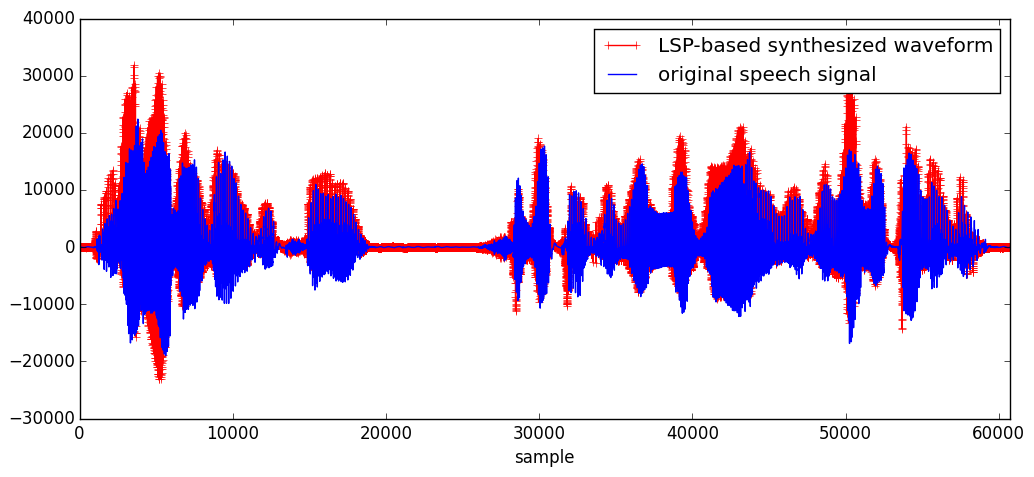

In [15]:
l = lpc2lsp(estimate(LinearPredictionCoef(15), xw))
y = synthesis(base_excitation, l, hopsize)
wavcompare(x, y, label="LSP-based synthesized waveform")
inline_audioplayer(round(Int16, clamp(y, typemin(Int16), typemax(Int16))), fs)